In [1]:
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import os
import json
import shutil
import random
import fnmatch
from pprint import pprint
from IPython.display import display, Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, GlobalMaxPooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

2023-12-07 11:58:40.520446: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# Might as well check, because this can be a mess...
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow:", tf.__version__)
print("Numpy:", np.__version__)

# Apparently prevents out-of-memory errors
gpus = tf.config.experimental.list_physical_devices("GPU")

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs Available:  2
Tensorflow: 2.4.1
Numpy: 1.23.5


2023-12-07 11:58:45.090171: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-12-07 11:58:45.092691: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-12-07 11:58:45.136622: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.635GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-12-07 11:58:45.136932: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.7715GHz coreCount: 20 deviceMemorySize: 7.92GiB deviceMemoryBandwidth: 298.32GiB/s
2023-12-07 11:58:45.136957: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so

In [6]:
def load_annotations(annot_path):
    with open(annot_path.numpy(), "r", encoding = "utf-8") as f:
        label = json.load(f)
        
        # Grab only first label["coords"]
    return [label["class"]], label["coords"]


train_labels = tf.data.Dataset.list_files("./pipeline-data/train-transformed/annotations/*json", 
                                          shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_annotations, [x], [tf.uint8, tf.float16]))


test_labels = tf.data.Dataset.list_files("./pipeline-data/test-transformed/annotations/*json", 
                                          shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_annotations, [x], [tf.uint8, tf.float16]))


val_labels = tf.data.Dataset.list_files("./pipeline-data/val-transformed/annotations/*json", 
                                          shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_annotations, [x], [tf.uint8, tf.float16]))

In [7]:
def load_image(x):
    byte_image = tf.io.read_file(x)
    image = tf.io.decode_jpeg(byte_image)
    return image

In [8]:
train_images = tf.data.Dataset.list_files("./pipeline-data/train-transformed/images/*jpg", shuffle = False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (256, 256)))
train_images = train_images.map(lambda x : x/255)

test_images = tf.data.Dataset.list_files("./pipeline-data/test-transformed/images/*jpg", shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (256, 256)))
test_images = test_images.map(lambda x : x/255)

val_images = tf.data.Dataset.list_files("./pipeline-data/val-transformed/images/*jpg", shuffle = False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (256, 256)))
val_images = val_images.map(lambda x : x/255)

print("Train:", len(train_images), len(train_labels))
print("Test:", len(test_images), len(test_labels))
print("Val:", len(val_images), len(val_labels))

Train: 4900 4900
Test: 1050 1050
Val: 1060 1060


In [9]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(32)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1100)
test = test.batch(32)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1100)
val = val.batch(32)
val = val.prefetch(4)

In [10]:
def build_model():
    
    input_layer = Input(shape = (256, 256, 3))
    # Using VGG16 here
    vgg16 = VGG16(include_top = False)(input_layer)
    
    
    # ============= Classification =======================================================
    condensing_layer_1 = GlobalMaxPooling2D()(vgg16)
    classification_layer_1 = Dense(512, activation = "relu")(condensing_layer_1)
    classification_output_layer = Dense(1, activation = "sigmoid")(classification_layer_1)
    
    
    # ============= Bounding Box Regression ==============================================
    condensing_layer_2 = GlobalMaxPooling2D()(vgg16)
    regression_layer_1 = Dense(1024, activation = "relu")(condensing_layer_2)
    dropout_layer_1 = Dropout(0.5)(regression_layer_1)
    regression_layer_2 = Dense(128, activation = "relu")(dropout_layer_1)
    regression_output_layer = Dense(4, activation = "sigmoid")(regression_layer_2)
    
    
    
    myModel = Model(inputs = input_layer, outputs = [classification_output_layer, regression_output_layer])
    myModel.build(input_shape = (None, 256, 256, 3))
    return myModel

In [11]:
class FaceLocalizer3(Model):
    def __init__(self, myModel, **kwargs):
        super().__init__(**kwargs)
        self.model = myModel
        
    def compile(self, optimizer, classification_loss, localization_loss, **kwargs):
        super().compile(**kwargs)
        self.classification_loss = classification_loss
        self.localization_loss = localization_loss
        self.optimizer = optimizer
    
    # One batch at a time, of course
    def train_step(self, batch, **kwargs):
        # X = image
        # y = labels
        # y[0] = classes, y[1] = bounding box coordinates
        X, y = batch
        
        with tf.GradientTape() as tape:
            # Make a prediction from the model by passing through an image
            classes, coords = self.model(X, training = True)
            
            # Calculate losses
            batch_classification_loss = self.classification_loss(y[0], classes)
            batch_localization_loss = self.localization_loss(tf.cast(y[1], tf.float32), coords)
            
            # Could change how this is calculated - Chagning it from 0.5 to 0.15, making it "matter" even less
            total_loss = batch_localization_loss + 0.15 * batch_classification_loss
            
            gradient = tape.gradient(total_loss, self.model.trainable_variables)
            
        # This is actually the back propagation
        optimizer.apply_gradients(zip(gradient, self.model.trainable_variables))
        
        return {"total_loss": total_loss, 
                "classification_loss": batch_classification_loss, 
                "localization_loss": batch_localization_loss}
    
    def test_step(self, batch, **kwargs):
        X, y = batch
        
        classes, coords = self.model(X, training = False)
        
        batch_classification_loss = self.classification_loss(y[0], classes)
        batch_localization_loss = self.localization_loss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localization_loss + 0.5 * batch_classification_loss
        
        return {"total_loss": total_loss, 
                "classification_loss": batch_classification_loss, 
                "localization_loss": batch_localization_loss}
        
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [14]:
def localization_loss(y_true, y_predicted):
    
    delta_coords = tf.reduce_sum(tf.square(y_true[:,:2] - y_predicted[:,:2]))
    # print("delta_coords = ", delta_coords)
    
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    # print("h_true = ", h_true)
    # print("w_true = ", w_true)
    
    h_predicted = y_predicted[:,3] - y_predicted[:,1]
    w_predicted = y_predicted[:,2] - y_predicted[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_predicted) + tf.square(h_true - h_predicted))
    
    return delta_coords + delta_size


classification_loss = tf.keras.losses.BinaryCrossentropy()
localization_loss = localization_loss

batches_per_epoch = len(train)
learning_rate_decay = (1. / 0.8 - 1)/batches_per_epoch
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, decay = learning_rate_decay)

In [15]:
newModel = build_model()
newModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_3[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_3 (GlobalM (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 1024)         525312      global_max_pooling2d_3[0][0]     
____________________________________________________________________________________________

In [16]:
model_build_4 = FaceLocalizer3(newModel)

In [17]:
model_build_4.compile(optimizer, 
              classification_loss = classification_loss, 
              localization_loss = localization_loss)

In [18]:
%%time
history = model_build_4.fit(train, 
                    validation_data = val, 
                    epochs = 32)

Epoch 1/32


2023-12-07 12:02:37.112012: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-12-07 12:02:37.123654: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3099995000 Hz
2023-12-07 12:02:37.362120: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-12-07 12:02:47.346809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2262 of 5000
2023-12-07 12:02:57.342689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4431 of 5000
2023-12-07 12:02:59.543253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.
2023-12-07 12:02:59.622504: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-12-07 12:03:01.720112: W ten

154/154 [==============================] - 183s 645ms/step - total_loss: 3.0239 - classification_loss: 0.1122 - localization_loss: 3.0070 - val_total_loss: 0.0463 - val_classification_loss: 0.0114 - val_localization_loss: 0.0406
Epoch 2/32


2023-12-07 12:05:49.831186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3410 of 5000
2023-12-07 12:05:55.310085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 248ms/step - total_loss: 0.7577 - classification_loss: 0.0165 - localization_loss: 0.7552 - val_total_loss: 0.0067 - val_classification_loss: 0.0033 - val_localization_loss: 0.0050
Epoch 3/32


2023-12-07 12:06:43.522504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2765 of 5000
2023-12-07 12:06:52.510913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 58s 250ms/step - total_loss: 0.4195 - classification_loss: 0.0035 - localization_loss: 0.4190 - val_total_loss: 0.0463 - val_classification_loss: 5.9079e-04 - val_localization_loss: 0.0460
Epoch 4/32


2023-12-07 12:07:41.094464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3882 of 5000
2023-12-07 12:07:43.932503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 51s 250ms/step - total_loss: 0.3371 - classification_loss: 0.0019 - localization_loss: 0.3369 - val_total_loss: 2.2696 - val_classification_loss: 1.6119 - val_localization_loss: 1.4636
Epoch 5/32


2023-12-07 12:08:32.379100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3243 of 5000
2023-12-07 12:08:37.752990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 246ms/step - total_loss: 0.2962 - classification_loss: 0.0016 - localization_loss: 0.2959 - val_total_loss: 0.0199 - val_classification_loss: 3.0056e-04 - val_localization_loss: 0.0197
Epoch 6/32


2023-12-07 12:09:25.714723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3051 of 5000
2023-12-07 12:09:32.782053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 56s 254ms/step - total_loss: 0.2594 - classification_loss: 6.3175e-04 - localization_loss: 0.2593 - val_total_loss: 0.0176 - val_classification_loss: 4.5255e-04 - val_localization_loss: 0.0173
Epoch 7/32


2023-12-07 12:10:21.921687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3758 of 5000
2023-12-07 12:10:25.200909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 259ms/step - total_loss: 0.2267 - classification_loss: 4.3345e-04 - localization_loss: 0.2267 - val_total_loss: 0.0094 - val_classification_loss: 6.6280e-04 - val_localization_loss: 0.0091
Epoch 8/32


2023-12-07 12:11:15.047662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4171 of 5000
2023-12-07 12:11:17.485104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 254ms/step - total_loss: 0.2109 - classification_loss: 3.1886e-04 - localization_loss: 0.2108 - val_total_loss: 0.0127 - val_classification_loss: 7.3488e-04 - val_localization_loss: 0.0123
Epoch 9/32


2023-12-07 12:12:06.611801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2689 of 5000
2023-12-07 12:12:13.191836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 56s 253ms/step - total_loss: 0.1902 - classification_loss: 2.7934e-04 - localization_loss: 0.1902 - val_total_loss: 0.0089 - val_classification_loss: 1.9409e-04 - val_localization_loss: 0.0088
Epoch 10/32


2023-12-07 12:13:02.181195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2789 of 5000
2023-12-07 12:13:10.376925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 56s 244ms/step - total_loss: 0.1811 - classification_loss: 2.1057e-04 - localization_loss: 0.1811 - val_total_loss: 0.0092 - val_classification_loss: 3.7433e-05 - val_localization_loss: 0.0091
Epoch 11/32


2023-12-07 12:13:57.947194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3766 of 5000
2023-12-07 12:14:01.216941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 51s 248ms/step - total_loss: 0.1654 - classification_loss: 1.7236e-04 - localization_loss: 0.1653 - val_total_loss: 1.7327e-04 - val_classification_loss: 1.8133e-04 - val_localization_loss: 8.2605e-05
Epoch 12/32


2023-12-07 12:14:49.417415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3764 of 5000
2023-12-07 12:14:51.726768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 255ms/step - total_loss: 0.1653 - classification_loss: 1.5809e-04 - localization_loss: 0.1653 - val_total_loss: 0.0286 - val_classification_loss: 5.2567e-04 - val_localization_loss: 0.0283
Epoch 13/32


2023-12-07 12:15:41.011267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3019 of 5000
2023-12-07 12:15:46.417502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 56s 264ms/step - total_loss: 0.1539 - classification_loss: 1.5281e-04 - localization_loss: 0.1539 - val_total_loss: 0.0073 - val_classification_loss: 8.1261e-04 - val_localization_loss: 0.0069
Epoch 14/32


2023-12-07 12:16:37.096913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4113 of 5000
2023-12-07 12:16:38.919579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 51s 253ms/step - total_loss: 0.1457 - classification_loss: 1.1763e-04 - localization_loss: 0.1457 - val_total_loss: 0.0373 - val_classification_loss: 1.6024e-04 - val_localization_loss: 0.0372
Epoch 15/32


2023-12-07 12:17:27.947943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3321 of 5000
2023-12-07 12:17:31.743145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 249ms/step - total_loss: 0.1414 - classification_loss: 1.1362e-04 - localization_loss: 0.1414 - val_total_loss: 0.0223 - val_classification_loss: 5.4288e-05 - val_localization_loss: 0.0223
Epoch 16/32


2023-12-07 12:18:20.169921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3073 of 5000
2023-12-07 12:18:25.296438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 249ms/step - total_loss: 0.1316 - classification_loss: 1.1062e-04 - localization_loss: 0.1316 - val_total_loss: 0.0041 - val_classification_loss: 2.9457e-04 - val_localization_loss: 0.0039
Epoch 17/32


2023-12-07 12:19:13.583239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3298 of 5000
2023-12-07 12:19:19.224828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 246ms/step - total_loss: 0.1292 - classification_loss: 8.9413e-05 - localization_loss: 0.1292 - val_total_loss: 0.0018 - val_classification_loss: 5.4769e-04 - val_localization_loss: 0.0015
Epoch 18/32


2023-12-07 12:20:07.122862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3331 of 5000
2023-12-07 12:20:11.939258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 243ms/step - total_loss: 0.1220 - classification_loss: 8.6902e-05 - localization_loss: 0.1220 - val_total_loss: 0.0033 - val_classification_loss: 1.8348e-04 - val_localization_loss: 0.0032
Epoch 19/32


2023-12-07 12:20:59.417818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2809 of 5000
2023-12-07 12:21:06.425669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 56s 252ms/step - total_loss: 0.1215 - classification_loss: 7.1992e-05 - localization_loss: 0.1215 - val_total_loss: 0.0123 - val_classification_loss: 3.7104e-06 - val_localization_loss: 0.0123
Epoch 20/32


2023-12-07 12:21:55.291649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3155 of 5000
2023-12-07 12:21:58.487690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 51s 244ms/step - total_loss: 0.1136 - classification_loss: 7.8870e-05 - localization_loss: 0.1135 - val_total_loss: 0.0073 - val_classification_loss: 1.6655e-04 - val_localization_loss: 0.0073
Epoch 21/32


2023-12-07 12:22:46.184973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3016 of 5000
2023-12-07 12:22:53.297177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 241ms/step - total_loss: 0.1113 - classification_loss: 6.2010e-05 - localization_loss: 0.1113 - val_total_loss: 0.0381 - val_classification_loss: 1.2517e-06 - val_localization_loss: 0.0381
Epoch 22/32


2023-12-07 12:23:40.391047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2829 of 5000
2023-12-07 12:23:48.647250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 57s 250ms/step - total_loss: 0.1091 - classification_loss: 7.1554e-05 - localization_loss: 0.1091 - val_total_loss: 0.0395 - val_classification_loss: 5.1518e-05 - val_localization_loss: 0.0394
Epoch 23/32


2023-12-07 12:24:37.233541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3504 of 5000
2023-12-07 12:24:42.010438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 252ms/step - total_loss: 0.1046 - classification_loss: 5.3702e-05 - localization_loss: 0.1046 - val_total_loss: 0.0188 - val_classification_loss: 1.6273e-05 - val_localization_loss: 0.0188
Epoch 24/32


2023-12-07 12:25:30.793794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3177 of 5000
2023-12-07 12:25:36.919835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 249ms/step - total_loss: 0.1010 - classification_loss: 4.9101e-05 - localization_loss: 0.1010 - val_total_loss: 0.0167 - val_classification_loss: 4.3363e-06 - val_localization_loss: 0.0167
Epoch 25/32


2023-12-07 12:26:25.340048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3538 of 5000
2023-12-07 12:26:30.127423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 246ms/step - total_loss: 0.0944 - classification_loss: 5.4984e-05 - localization_loss: 0.0944 - val_total_loss: 0.0018 - val_classification_loss: 7.4557e-05 - val_localization_loss: 0.0018
Epoch 26/32


2023-12-07 12:27:18.021826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3077 of 5000
2023-12-07 12:27:24.020989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 244ms/step - total_loss: 0.0972 - classification_loss: 5.7823e-05 - localization_loss: 0.0972 - val_total_loss: 0.0100 - val_classification_loss: 0.0016 - val_localization_loss: 0.0092
Epoch 27/32


2023-12-07 12:28:11.715737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2930 of 5000
2023-12-07 12:28:18.076257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 245ms/step - total_loss: 0.0914 - classification_loss: 4.6084e-05 - localization_loss: 0.0914 - val_total_loss: 0.0090 - val_classification_loss: 4.2013e-04 - val_localization_loss: 0.0088
Epoch 28/32


2023-12-07 12:29:05.847584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3292 of 5000
2023-12-07 12:29:12.863914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 241ms/step - total_loss: 0.0884 - classification_loss: 4.7370e-05 - localization_loss: 0.0884 - val_total_loss: 0.0032 - val_classification_loss: 1.3994e-04 - val_localization_loss: 0.0031
Epoch 29/32


2023-12-07 12:30:00.105617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3374 of 5000
2023-12-07 12:30:05.486540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 243ms/step - total_loss: 0.0871 - classification_loss: 4.9394e-05 - localization_loss: 0.0870 - val_total_loss: 0.1088 - val_classification_loss: 0.1291 - val_localization_loss: 0.0442
Epoch 30/32


2023-12-07 12:30:52.908205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2904 of 5000
2023-12-07 12:31:00.867707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 57s 251ms/step - total_loss: 0.0868 - classification_loss: 3.7723e-05 - localization_loss: 0.0868 - val_total_loss: 0.0128 - val_classification_loss: 1.3963e-04 - val_localization_loss: 0.0128
Epoch 31/32


2023-12-07 12:31:49.615952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3101 of 5000
2023-12-07 12:31:56.629137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 56s 250ms/step - total_loss: 0.0828 - classification_loss: 3.5580e-05 - localization_loss: 0.0828 - val_total_loss: 0.0203 - val_classification_loss: 4.2330e-04 - val_localization_loss: 0.0201
Epoch 32/32


2023-12-07 12:32:45.149413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3163 of 5000
2023-12-07 12:32:50.068385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 253ms/step - total_loss: 0.0828 - classification_loss: 3.6727e-05 - localization_loss: 0.0828 - val_total_loss: 0.0180 - val_classification_loss: 2.3664e-04 - val_localization_loss: 0.0179
CPU times: user 25min 11s, sys: 3min 5s, total: 28min 16s
Wall time: 30min 52s


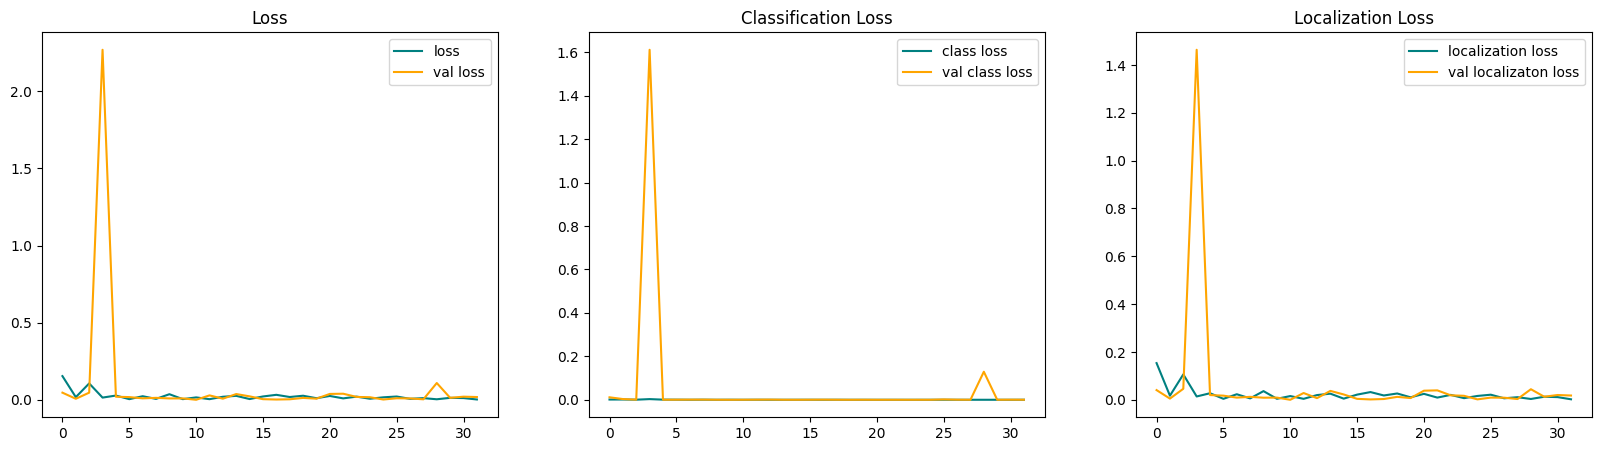

In [19]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(history.history['total_loss'], color='teal', label='loss')
ax[0].plot(history.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(history.history['classification_loss'], color='teal', label='class loss')
ax[1].plot(history.history['val_classification_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(history.history['localization_loss'], color='teal', label='localization loss')
ax[2].plot(history.history['val_localization_loss'], color='orange', label='val localizaton loss')
ax[2].title.set_text('Localization Loss')
ax[2].legend()

plt.show()

In [20]:
model_build_4.compute_output_shape(input_shape = (None, 256, 256, 3))
model_build_4.save("model_4", save_format = "tf")

2023-12-07 12:35:47.969090: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_4/assets
